In [230]:
# import warnings
# warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import scipy.sparse as sp
from scipy.sparse import load_npz
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
from pathlib import Path

import torch

from cell import utils
from cell.utils import link_prediction_performance, edge_overlap
from cell.cell import Cell, EdgeOverlapCriterion, LinkPredictionCriterion
from cell.graph_statistics import compute_graph_statistics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [231]:
#train_graph 
_A_obs, _X_obs, _z_obs = utils.load_npz('../data/eps_neighbour_graph.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

Selecting 1 largest connected components


In [232]:
with np.load('../data/eps_neighbour_graph.npz', allow_pickle=True) as loader:
    coos = loader['coos']
    coos = coos[lcc, :]

In [233]:
print(_N)

153


In [234]:
Gs = dict()
df = pd.DataFrame()

In [235]:
Gs['true'] = _A_obs

In [236]:
val_share = 0.05
test_share = 0.1
seed = 42 #481516234

train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=False)

train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

In [237]:
def run(g_type='cell', loss_fn=None, criterion='eo', nsteps=200):
    if criterion == 'eo':
        callbacks = [EdgeOverlapCriterion(invoke_every=10, edge_overlap_limit=.5)]
    else:
        callbacks = [LinkPredictionCriterion(invoke_every=2,
                                                val_ones=val_ones,
                                            val_zeros=val_zeros,
                                                max_patience=3)]
    model = Cell(A=train_graph,
             H=9,
             g_type=g_type,
             loss_fn=loss_fn,
             callbacks=callbacks)

    # train model 
    model.train(steps=nsteps,
                optimizer_fn=torch.optim.Adam,
                optimizer_args={'lr': 0.1,
                                'weight_decay': 1e-5})
    
    roc_auc, avg_prec = link_prediction_performance(scores_matrix=model._scores_matrix, val_ones=test_ones, val_zeros=test_zeros)
    print(f'ROC-AUC: {roc_auc}, AVG_PREC: {avg_prec}')

    generated_graphs = [model.sample_graph() for _ in range(5)]
    stats = [compute_graph_statistics(gg) for gg in generated_graphs]
    stat_df = pd.DataFrame({k: [s[k] for s in stats] for k in stats[0].keys()})
    stat_df = stat_df.mean()
    stat_df['roc-auc'] = roc_auc
    stat_df['avg-prec'] = avg_prec

    return stat_df.T, generated_graphs

    

In [238]:
method = 'cell'
options = dict(g_type='cell')

stat_df, generated_graphs = run(**options)
df[method] = stat_df
Gs[method] = generated_graphs[0]

Step:  10/200 Loss: 2.68654 Edge-Overlap: 0.376 Total-Time: 0
Step:  20/200 Loss: 1.60217 Edge-Overlap: 0.833 Total-Time: 0
ROC-AUC: 0.7935267857142857, AVG_PREC: 0.8144593879480462


In [239]:
method = 'local cell'
options = dict(g_type='cell', loss_fn='local_cell')

stat_df, generated_graphs = run(**options)
df[method] = stat_df
Gs[method] = generated_graphs[0]

Step:  10/200 Loss: 5.39025 Edge-Overlap: 0.418 Total-Time: 0
Step:  20/200 Loss: 3.16467 Edge-Overlap: 0.852 Total-Time: 0
ROC-AUC: 0.8694196428571427, AVG_PREC: 0.8876831984436921


In [240]:
method = 'svd'
options = dict(g_type='svd')

stat_df, generated_graphs = run(**options)
df[method] = stat_df
Gs[method] = generated_graphs[0]

Step:  10/200 Loss: 3.97791 Edge-Overlap: 0.110 Total-Time: 0
Step:  20/200 Loss: 2.11711 Edge-Overlap: 0.829 Total-Time: 0
ROC-AUC: 0.8158482142857143, AVG_PREC: 0.8020617414936347


In [241]:
method = 'nonlin cell'
options = dict(g_type='fc')

stat_df, generated_graphs = run(**options)
df[method] = stat_df
Gs[method] = generated_graphs[0]

Step:  10/200 Loss: 2.85760 Edge-Overlap: 0.411 Total-Time: 0
Step:  20/200 Loss: 1.69611 Edge-Overlap: 0.817 Total-Time: 0
ROC-AUC: 0.8225446428571429, AVG_PREC: 0.8544200296937886


In [242]:
df['gt'] = list(compute_graph_statistics(_A_obs).values()) + [1, 1]
df

,cell,local cell,svd,nonlin cell,gt
d_max,8.200000,10.000000,8.800000,10.400000,10.000000
d_min,1.000000,1.000000,1.000000,1.000000,1.000000
d,3.437908,3.437908,3.437908,3.437908,4.052288
LCC,153.000000,151.200000,143.600000,150.400000,153.000000
wedge_count,846.000000,867.000000,862.200000,952.600000,1217.000000
claw_count,882.800000,981.000000,919.800000,1305.600000,1547.000000
triangle_count,76.600000,80.600000,91.400000,90.600000,210.000000
square_count,126.200000,132.000000,185.200000,197.600000,428.000000
power_law_exp,1.899797,1.905308,1.911978,1.938520,1.784310
gini,0.260772,0.269574,0.273685,0.311534,0.260405


No handles with labels found to put in legend.


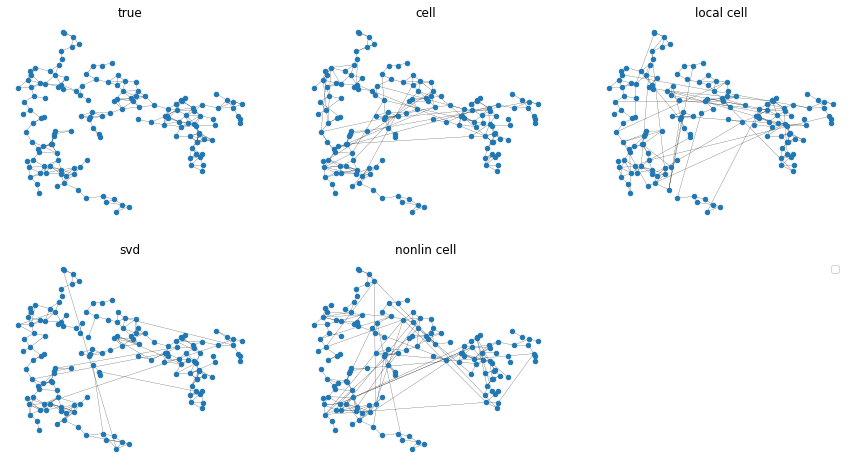

In [246]:
import itertools

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

methods = ['true', 'cell', 'local cell', 'svd', 'nonlin cell']
for ax, name in zip(itertools.chain.from_iterable(axs), methods):
    G = nx.from_numpy_array(Gs[name].toarray())
    nx.draw(G, node_size=20, width=0.2, pos=coos, ax=ax)
    ax.set_title(name)
for ax in list(itertools.chain.from_iterable(axs))[len(methods):]:
    ax.axis('off')
plt.legend()
plt.savefig('../img/eps_neighbour_graph.png')
plt.show()